In [285]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

import pickle
from joblib import dump
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [286]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [287]:


query = """
    select *
       from eigensonne_dwh.public.lead_scoring_sample_1 """
    
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue
0,00Q5J000003awZpUAI,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,0
1,00Q5J000002rzxgUAA,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,3
2,00Q5J000003YdHPUA0,KP,affiliate,Baden-Württemberg,Regular,0,0,0,30
3,00Q5J000003aZumUAE,Website,cpc,Baden-Württemberg,Regular,0,0,0,38
4,00Q5J000003ak0FUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,0,0,0,0


In [288]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [289]:
print(base.shape)
base.dtypes

(21658, 9)


id                           object
lead_source                  object
lead_medium                  object
bundesland                   object
record_type_name_c           object
has_opened                    int64
has_clicked_non_photo_url     int64
photo_uploaded                int64
time_in_queue                 int64
dtype: object

In [290]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         21658 non-null  object
 1   lead_source                21658 non-null  object
 2   lead_medium                21658 non-null  object
 3   bundesland                 21658 non-null  object
 4   record_type_name_c         21658 non-null  object
 5   has_opened                 21658 non-null  int64 
 6   has_clicked_non_photo_url  21658 non-null  int64 
 7   photo_uploaded             21658 non-null  int64 
 8   time_in_queue              21658 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.5+ MB


In [291]:
base.describe()

,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue
count,21658.000000,21658.000000,21658.000000,21658.000000
mean,0.709899,0.098763,0.178687,3.887016
std,0.453819,0.298350,0.383099,8.153655
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,113.000000


In [292]:
data = base.copy(deep=True)

In [293]:
#data=data.drop('has_been_wfp',axis=1)

In [294]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       21658
unique          8
top       Wattfox
freq         7012
Name: lead_source, dtype: object

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

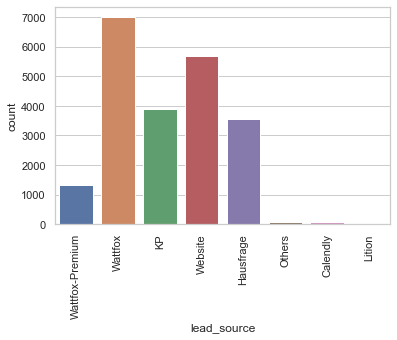

In [295]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [296]:
data.groupby(['lead_source'])['id'].count()

lead_source
Calendly             77
Hausfrage          3546
KP                 3892
Lition               40
Others               55
Wattfox            7012
Wattfox-Premium    1339
Website            5697
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

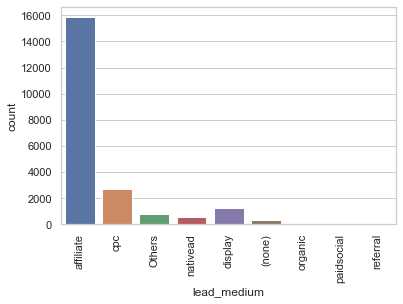

In [297]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [298]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)          339
Others          754
affiliate     15851
cpc            2691
display        1268
nativead        532
organic         116
paidsocial       63
referral         44
Name: id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

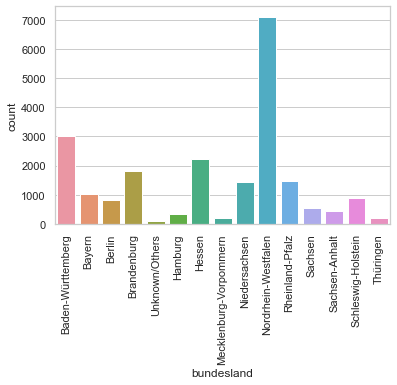

In [299]:
sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [300]:
data.groupby(['bundesland'])['id'].count()

bundesland
Baden-Württemberg         3017
Bayern                    1031
Berlin                     805
Brandenburg               1811
Hamburg                    346
Hessen                    2237
Mecklenburg-Vorpommern     196
Niedersachsen             1437
Nordrhein-Westfalen       7113
Rheinland-Pfalz           1478
Sachsen                    553
Sachsen-Anhalt             424
Schleswig-Holstein         900
Thüringen                  214
Unknown/Others              96
Name: id, dtype: int64

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

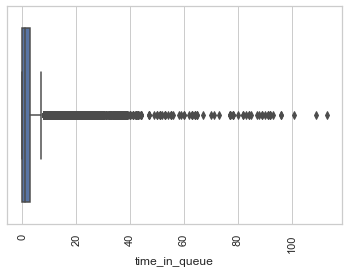

In [301]:
plt1 = sns.boxplot(data['time_in_queue'])
xticks(rotation = 90)

<ipython-input-302-aa16c8108611>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_in_queue'][data['time_in_queue'] <= percentiles[0]] = percentiles[0]


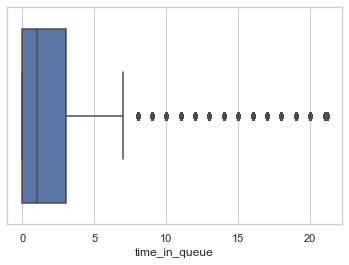

In [302]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
percentiles = data['time_in_queue'].quantile([0.00,0.95]).values
data['time_in_queue'][data['time_in_queue'] <= percentiles[0]] = percentiles[0]
data['time_in_queue'][data['time_in_queue'] >= percentiles[1]] = percentiles[1]
sns.boxplot(data['time_in_queue'])

In [303]:
data['time_in_queue'].median()

1.0

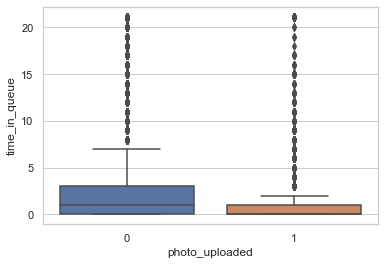

In [304]:
sns.boxplot(y = 'time_in_queue', x = 'photo_uploaded', data = data)
#median for converted and non converted leads is different

In [305]:
data['record_type_name_c'].describe()


count       21658
unique          2
top       Regular
freq        16084
Name: record_type_name_c, dtype: object

In [306]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                           0.0
lead_source                  0.0
lead_medium                  0.0
bundesland                   0.0
record_type_name_c           0.0
has_opened                   0.0
has_clicked_non_photo_url    0.0
photo_uploaded               0.0
time_in_queue                0.0
dtype: float64

In [307]:
#Exploratory Data Analytics
# Univariate Analysis 

In [308]:
Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

17.868685935912826

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

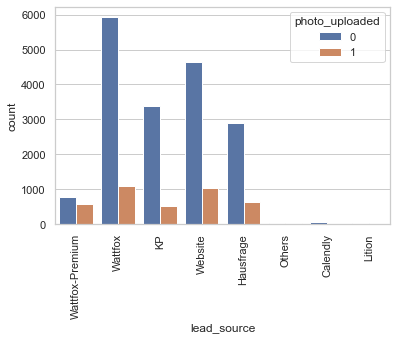

In [309]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

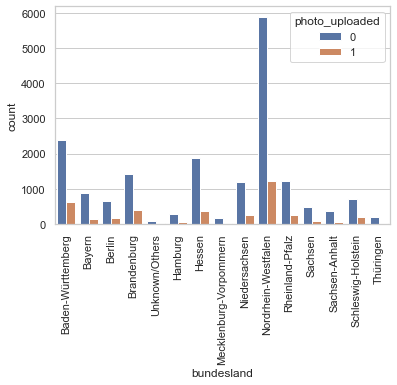

In [310]:
#lead_source 
sns.countplot(x = "bundesland", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

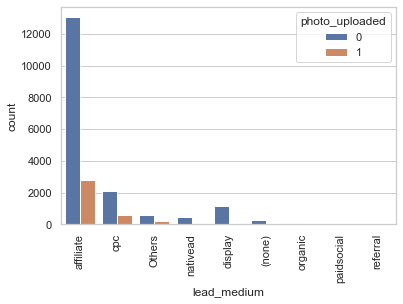

In [311]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

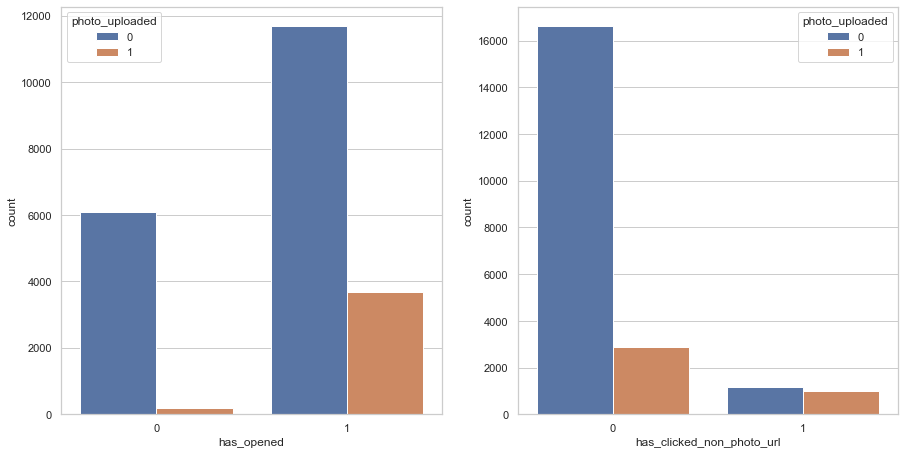

In [312]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_uploaded", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_uploaded", data = data, ax = axs[1])

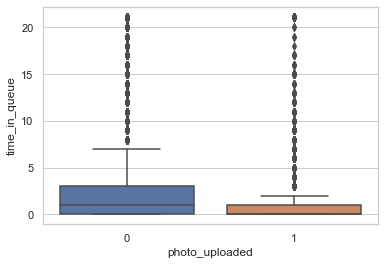

In [313]:
sns.boxplot(y = 'time_in_queue', x = 'photo_uploaded', data = data)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

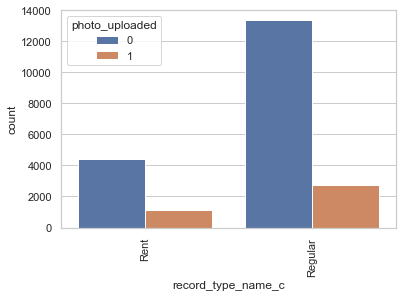

In [314]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_uploaded", data = data)
xticks(rotation = 90)

In [315]:
d = data.corr()
m = ((d>0.5)&(d!=1))|((d<-0.5)&(d!=-1))
d[m].stack().drop_duplicates().round(3).to_dict()

{}

In [316]:
data.head(10)

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue
0,00Q5J000003awZpUAI,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,0.00
1,00Q5J000002rzxgUAA,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,3.00
2,00Q5J000003YdHPUA0,KP,affiliate,Baden-Württemberg,Regular,0,0,0,21.15
3,00Q5J000003aZumUAE,Website,cpc,Baden-Württemberg,Regular,0,0,0,21.15
4,00Q5J000003ak0FUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,0,0,0,0.00
5,00Q5J000003aWZyUAM,Website,cpc,Baden-Württemberg,Regular,1,0,0,2.00
6,00Q5J000002rkyYUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Regular,1,0,0,0.00
7,00Q5J000003c0X1UAI,Website,cpc,Baden-Württemberg,Rent,1,0,1,0.00
8,00Q5J000002rhZ7UAI,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,21.15
9,00Q5J000003aQ2HUAU,Website,Others,Baden-Württemberg,Regular,1,0,0,0.00


In [317]:
# Data Preparation



In [318]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source',# 'radius_category',
                           'lead_medium','bundesland'
                             ]], drop_first=True) #True
                       

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [319]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003awZpUAI,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00Q5J000002rzxgUAA,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,0,3.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000003YdHPUA0,KP,affiliate,Baden-Württemberg,Regular,0,0,0,21.15,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003aZumUAE,Website,cpc,Baden-Württemberg,Regular,0,0,0,21.15,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003ak0FUAQ,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,0,0,0,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [320]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',#'radius_category',
                             'record_type_name_c'], axis = 1)


In [321]:
data.head(10)

,id,has_opened,has_clicked_non_photo_url,photo_uploaded,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003awZpUAI,1,1,0,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00Q5J000002rzxgUAA,1,0,0,3.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00Q5J000003YdHPUA0,0,0,0,21.15,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003aZumUAE,0,0,0,21.15,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00Q5J000003ak0FUAQ,0,0,0,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,00Q5J000003aWZyUAM,1,0,0,2.00,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,00Q5J000002rkyYUAQ,1,0,0,0.00,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,00Q5J000003c0X1UAI,1,0,1,0.00,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00Q5J000002rhZ7UAI,1,0,0,21.15,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,00Q5J000003aQ2HUAU,1,0,0,0.00,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [322]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_uploaded'], axis=1)
X.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,1,1,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,3.00,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,21.15,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,21.15,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0.00,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [323]:
y = data['photo_uploaded']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_uploaded, dtype: int64

In [324]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.3, random_state=None)

In [325]:
X_train.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
16897,1,0,0.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5500,1,0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9115,1,0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21094,1,0,1.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15849,1,0,7.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [326]:
#feature scaling
scaler = StandardScaler()


X_train[['time_in_queue']] = scaler.fit_transform(
    X_train[['time_in_queue']])

#X_train[['distance']] = scaler.fit_transform(
#    X_train[['distance']])

X_train.head()

<ipython-input-326-dfa6a3991bf6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['time_in_queue']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
16897,1,0,-0.568917,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5500,1,0,-0.568917,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9115,1,0,-0.568917,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21094,1,0,-0.399270,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15849,1,0,0.618610,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [327]:
#How many conversions do we have 

Converted = (sum(data['photo_uploaded'])/len(data['photo_uploaded'].index))*100
Converted

17.868685935912826

In [328]:
#Model building 

In [329]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1_fit=logm1.fit()
logm1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                15160
Model:                            GLM   Df Residuals:                    15126
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5853.9
Date:                Wed, 17 Feb 2021   Deviance:                       11708.
Time:                        15:06:31   Pearson chi2:                 1.50e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.7088      0.602     -7.827      0.000      -5.888      -3.530
has_opened                            2.1342      0.093     22.890      0.000       1.951       2.317
has_clicked_non_photo_url             1.3230      0.063     20.883      0.000       1.199       1.447
time_in_queue                        -0.6931      0.040    -17.221      0.000      -0.772      -0.614
record_type_name_c_Rent               0.1596      0.055      2.885      0.004       0.051       0.268
lead_source_Hausfrage                 3.6647      1.160      3.160      0.002       1.392       5.937
lead_source_KP                        3.4718      1.160      2.994      0.003       1.199       5.745
lead_source_Lition                    4.1633      1.252      3.326      0.001       1.710       6.617
lead_source_Others                    3.3721      0.833      4.050      0.000       1.740       5.004
lead_source_Wattfox                   3.4680      1.159      2.991      0.003       1.196       5.740
lead_source_Wattfox-Premium           4.3929      1.161      3.783      0.000       2.117       6.669
lead_source_Website                   1.1152      0.561      1.989      0.047       0.016       2.214
lead_medium_Others                    0.4897      0.225      2.176      0.030       0.049       0.931
lead_medium_affiliate                -2.4785      1.042     -2.379      0.017      -4.520      -0.437
lead_medium_cpc                       0.2745      0.202      1.359      0.174      -0.121       0.670
lead_medium_display                  -0.7157      0.229     -3.124      0.002      -1.165      -0.267
lead_medium_nativead                 -0.3016      0.250     -1.205      0.228      -0.792       0.189
lead_medium_organic                   0.7917      0.328      2.414      0.016       0.149       1.435
lead_medium_paidsocial                0.5035      0.408      1.235      0.217      -0.296       1.303
lead_medium_referral                  0.2752      0.685      0.402      0.688      -1.067       1.617
bundesland_Bayern                    -0.3533      0.129     -2.739      0.006      -0.606      -0.100
bundesland_Berlin                     0.0024      0.130      0.019      0.985      -0.252       0.257
bundesland_Brandenburg               -0.0034      0.098     -0.035      0.972      -0.195       0.188
bundesland_Hamburg                   -0.1071      0.198     -0.541      0.589      -0.495       0.281
bundesland_Hessen                    -0.2167      0.095     -2.273      0.023      -0.404      -0.030
bundesland_Mecklenburg-Vorpommern    -0.6579      0.310     -2.126      0.034      -1.265      -0.051
bundesland_Niedersachsen             -0.0209      0.106     -0.197      0.844      -0.229       0.187
bundesland_Nordrhein-We

In [330]:


#logreg = LogisticRegression()

#rfe = RFE(logreg, 12)             
#rfe = rfe.fit(X_train, y_train)
#rfe.support_

In [331]:
#list(zip(X_train.columns, rfe.support_, rfe.ranking_))

In [332]:
#col = X_train.columns[rfe.support_]

#col

In [333]:
#X_train_sm = sm.add_constant(X_train[col])
X_train_sm = sm.add_constant(X_train)
#logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
#res = logm2.fit()
res=logm1_fit
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         photo_uploaded   No. Observations:                15160
Model:                            GLM   Df Residuals:                    15126
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5853.9
Date:                Wed, 17 Feb 2021   Deviance:                       11708.
Time:                        15:06:44   Pearson chi2:                 1.50e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -4.7088      0.602     -7.827      0.000      -5.888      -3.530
has_opened                            2.1342      0.093     22.890      0.000       1.951       2.317
has_clicked_non_photo_url             1.3230      0.063     20.883      0.000       1.199       1.447
time_in_queue                        -0.6931      0.040    -17.221      0.000      -0.772      -0.614
record_type_name_c_Rent               0.1596      0.055      2.885      0.004       0.051       0.268
lead_source_Hausfrage                 3.6647      1.160      3.160      0.002       1.392       5.937
lead_source_KP                        3.4718      1.160      2.994      0.003       1.199       5.745
lead_source_Lition                    4.1633      1.252      3.326      0.001       1.710       6.617
lead_source_Others                    3.3721      0.833      4.050      0.000       1.740       5.004
lead_source_Wattfox                   3.4680      1.159      2.991      0.003       1.196       5.740
lead_source_Wattfox-Premium           4.3929      1.161      3.783      0.000       2.117       6.669
lead_source_Website                   1.1152      0.561      1.989      0.047       0.016       2.214
lead_medium_Others                    0.4897      0.225      2.176      0.030       0.049       0.931
lead_medium_affiliate                -2.4785      1.042     -2.379      0.017      -4.520      -0.437
lead_medium_cpc                       0.2745      0.202      1.359      0.174      -0.121       0.670
lead_medium_display                  -0.7157      0.229     -3.124      0.002      -1.165      -0.267
lead_medium_nativead                 -0.3016      0.250     -1.205      0.228      -0.792       0.189
lead_medium_organic                   0.7917      0.328      2.414      0.016       0.149       1.435
lead_medium_paidsocial                0.5035      0.408      1.235      0.217      -0.296       1.303
lead_medium_referral                  0.2752      0.685      0.402      0.688      -1.067       1.617
bundesland_Bayern                    -0.3533      0.129     -2.739      0.006      -0.606      -0.100
bundesland_Berlin                     0.0024      0.130      0.019      0.985      -0.252       0.257
bundesland_Brandenburg               -0.0034      0.098     -0.035      0.972      -0.195       0.188
bundesland_Hamburg                   -0.1071      0.198     -0.541      0.589      -0.495       0.281
bundesland_Hessen                    -0.2167      0.095     -2.273      0.023      -0.404      -0.030
bundesland_Mecklenburg-Vorpommern    -0.6579      0.310     -2.126      0.034      -1.265      -0.051
bundesland_Niedersachsen             -0.0209      0.106     -0.197      0.844      -0.229       0.187
bundesland_Nordrhein-We

In [334]:
#col2 = col.drop(['lead_medium_nativead', 'lead_source_Hausfrage',
#                  'bundesland_Berlin','bundesland_Niedersachsen','bundesland_Rheinland-Pfalz',
#                'bundesland_Sachsen-Anhalt'],1)
#X_train_sm = sm.add_constant(X_train[col2])
#logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
#res = logm2.fit()
#res.summary()

In [335]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

16897    0.303526
5500     0.311307
9115     0.196624
21094    0.253655
15849    0.098551
14658    0.028727
18892    0.046222
19144    0.290540
3244     0.387062
3553     0.053352
dtype: float64

In [336]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.30352621, 0.31130685, 0.19662405, 0.2536547 , 0.09855066,
       0.02872658, 0.04622209, 0.29053989, 0.38706177, 0.05335166])

In [337]:
#
y_train_pred_final = pd.DataFrame({'photo_uploaded':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id
0,0,0.303526,16897
1,0,0.311307,5500
2,0,0.196624,9115
3,0,0.253655,21094
4,0,0.098551,15849


In [338]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted
0,0,0.303526,16897,0
1,0,0.311307,5500,0
2,0,0.196624,9115,0
3,0,0.253655,21094,0
4,0,0.098551,15849,0


In [339]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
print(confusion)


[[12197   290]
 [ 2277   396]]


In [340]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted))

0.8306728232189974


In [341]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
#vif['Features'] = X_train[col].columns
vif['Features'] = X_train.columns
#vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
12,lead_medium_affiliate,1402.02
8,lead_source_Wattfox,630.08
5,lead_source_KP,344.04
4,lead_source_Hausfrage,315.31
9,lead_source_Wattfox-Premium,115.84
10,lead_source_Website,16.15
13,lead_medium_cpc,7.77
6,lead_source_Lition,4.54
14,lead_medium_display,4.39
0,has_opened,3.64


In [342]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [343]:
TN

12197

In [344]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.14814814814814814

In [345]:
# Let us calculate specificity
TN / float(TN+FP)

0.976775846880756

In [346]:
# positive predictive value 
print (TP / float(TP+FP))

0.577259475218659


In [347]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8426834323614758


In [348]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

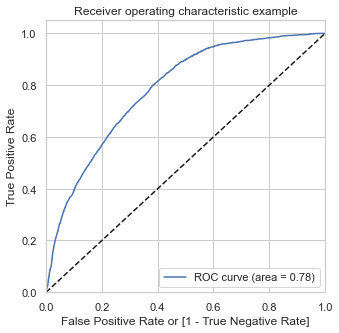

In [349]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_uploaded, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

In [350]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.303526,16897,0,1,1,1,1,0,0,0,0,0,0
1,0,0.311307,5500,0,1,1,1,1,0,0,0,0,0,0
2,0,0.196624,9115,0,1,1,0,0,0,0,0,0,0,0
3,0,0.253655,21094,0,1,1,1,0,0,0,0,0,0,0
4,0,0.098551,15849,0,1,0,0,0,0,0,0,0,0,0


In [351]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.176319  1.000000  0.000000
0.1   0.1  0.540369  0.921811  0.458717
0.2   0.2  0.688984  0.728769  0.680468
0.3   0.3  0.810620  0.393565  0.899896
0.4   0.4  0.829551  0.268238  0.949708
0.5   0.5  0.830673  0.148148  0.976776
0.6   0.6  0.825726  0.058736  0.989910
0.7   0.7  0.823351  0.026562  0.993914
0.8   0.8  0.823879  0.001871  0.999840
0.9   0.9  0.823813  0.000748  1.000000


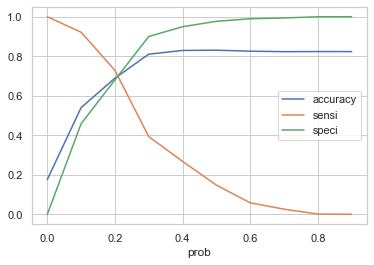

In [352]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [353]:
#### From the curve above, 0.2 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.303526,16897,0,1,1,1,1,0,0,0,0,0,0,1
1,0,0.311307,5500,0,1,1,1,1,0,0,0,0,0,0,1
2,0,0.196624,9115,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.253655,21094,0,1,1,1,0,0,0,0,0,0,0,1
4,0,0.098551,15849,0,1,0,0,0,0,0,0,0,0,0,0


In [354]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_uploaded,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,0.303526,16897,0,1,1,1,1,0,0,0,0,0,0,1,30
1,0,0.311307,5500,0,1,1,1,1,0,0,0,0,0,0,1,31
2,0,0.196624,9115,0,1,1,0,0,0,0,0,0,0,0,0,20
3,0,0.253655,21094,0,1,1,1,0,0,0,0,0,0,0,1,25
4,0,0.098551,15849,0,1,0,0,0,0,0,0,0,0,0,0,10


In [355]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7287691732136177

In [356]:
# Let us calculate specificity
TN / float(TN+FP)

0.6804676863938496

In [357]:
# Calculate false postive rate - predicting photo when customer did not send photo
print(FP/ float(TN+FP))

0.3195323136061504


In [358]:
# Positive predictive value 
print (TP / float(TP+FP))

0.3280565847086561


In [359]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9213836477987422


In [360]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_uploaded, y_train_pred_final.predicted )
confusion

array([[12197,   290],
       [ 2277,   396]])

In [361]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.577259475218659

In [362]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.14814814814814814

In [363]:
y_train_pred_final.photo_uploaded, y_train_pred_final.predicted

(0        0
 1        0
 2        0
 3        0
 4        0
         ..
 15155    0
 15156    0
 15157    0
 15158    0
 15159    1
 Name: photo_uploaded, Length: 15160, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 15155    0
 15156    0
 15157    0
 15158    0
 15159    0
 Name: predicted, Length: 15160, dtype: int64)

In [364]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_uploaded, y_train_pred_final.photo_upload_prob)

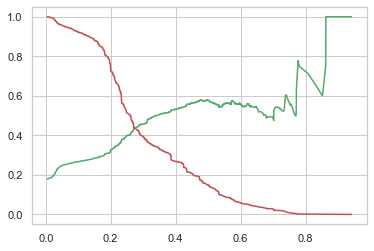

In [365]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [366]:
#Making predictions on the test set

X_test[['time_in_queue']] = scaler.fit_transform(X_test[['time_in_queue']])

X_train.head()

<ipython-input-366-32c7eeaa7025>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['time_in_queue']] = scaler.fit_transform(X_test[['time_in_queue']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
16897,1,0,-0.568917,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5500,1,0,-0.568917,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9115,1,0,-0.568917,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21094,1,0,-0.399270,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15849,1,0,0.618610,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [367]:
#X_test = X_test[col]
X_test.head()

,has_opened,has_clicked_non_photo_url,time_in_queue,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Lition,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_paidsocial,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
16661,1,0,-0.231462,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5701,1,0,-0.063765,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7555,0,0,-0.566857,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9830,1,0,-0.399160,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
19292,0,0,-0.566857,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [368]:
X_test_sm = sm.add_constant(X_test)

In [369]:
X_test.shape

(6498, 33)

In [370]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


16661    0.227224
5701     0.271997
7555     0.067969
9830     0.209897
19292    0.031413
4628     0.434140
9762     0.033983
18105    0.243278
11483    0.033362
19724    0.006941
dtype: float64

In [371]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
16661,0.227224
5701,0.271997
7555,0.067969
9830,0.209897
19292,0.031413


In [372]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_uploaded,id,0
0,1,16661,0.227224
1,0,5701,0.271997
2,0,7555,0.067969
3,1,9830,0.209897
4,0,19292,0.031413


In [373]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob
0,1,16661,0.227224
1,0,5701,0.271997
2,0,7555,0.067969
3,1,9830,0.209897
4,0,19292,0.031413


In [374]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_uploaded,id,photo_upload_prob,final_predicted
0,1,16661,0.227224,1
1,0,5701,0.271997,1
2,0,7555,0.067969,0
3,1,9830,0.209897,1
4,0,19292,0.031413,0


In [375]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_uploaded, y_pred_final.final_predicted)

0.693136349646045

In [376]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_uploaded, y_pred_final.final_predicted )
confusion2

array([[3592, 1709],
       [ 285,  912]])

In [377]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [378]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7619047619047619

In [379]:
# Let us calculate specificity
TN / float(TN+FP)

0.6776079984908507

In [380]:
y_pred_final['Lead_Score'] = y_pred_final.photo_upload_prob.map( lambda x: round(x*100))

In [381]:
print(y_pred_final.shape)
y_pred_final.head()

(6498, 5)


,photo_uploaded,id,photo_upload_prob,final_predicted,Lead_Score
0,1,16661,0.227224,1,23
1,0,5701,0.271997,1,27
2,0,7555,0.067969,0,7
3,1,9830,0.209897,1,21
4,0,19292,0.031413,0,3


In [382]:
y_train_pred_final=y_train_pred_final.drop(['predicted',0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],1)
print(y_train_pred_final.shape)
y_train_pred_final.head()

(15160, 5)


,photo_uploaded,photo_upload_prob,id,final_predicted,Lead_Score
0,0,0.303526,16897,1,30
1,0,0.311307,5500,1,31
2,0,0.196624,9115,0,20
3,0,0.253655,21094,1,25
4,0,0.098551,15849,0,10


In [383]:
y_pred_final=y_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]
y_train_pred_final=y_train_pred_final[['id','photo_uploaded','photo_upload_prob','final_predicted','Lead_Score']]

In [384]:
y_pred_final.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,16661,1,0.227224,1,23
1,5701,0,0.271997,1,27
2,7555,0,0.067969,0,7
3,9830,1,0.209897,1,21
4,19292,0,0.031413,0,3


In [385]:
pred_values=pd.concat([y_train_pred_final,y_pred_final]).reset_index(drop=True)
pred_values.shape

(21658, 5)

In [386]:
pred_values.head()

,id,photo_uploaded,photo_upload_prob,final_predicted,Lead_Score
0,16897,0,0.303526,1,30
1,5500,0,0.311307,1,31
2,9115,0,0.196624,0,20
3,21094,0,0.253655,1,25
4,15849,0,0.098551,0,10


In [387]:
Final= base.merge(pred_values, how='left',left_index=True,right_on='id', suffixes=('_left', '_right')).reset_index(drop=True)
Final.shape

(21658, 15)

In [388]:
Final.loc[Final.photo_uploaded_left != Final.photo_uploaded_right]

,id,id_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_uploaded_left,time_in_queue,id_right,photo_uploaded_right,photo_upload_prob,final_predicted,Lead_Score


In [389]:
Final=Final[['id_left','Lead_Score','photo_uploaded_left','lead_source','lead_medium','bundesland',#'radius_category','distance',
             'record_type_name_c','has_opened',	'has_clicked_non_photo_url',
             'time_in_queue']]
Final.head(50)

,id_left,Lead_Score,photo_uploaded_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,time_in_queue
0,00Q5J000003awZpUAI,77,0,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,1,1,0
1,00Q5J000002rzxgUAA,18,0,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,3
2,00Q5J000003YdHPUA0,0,0,KP,affiliate,Baden-Württemberg,Regular,0,0,30
3,00Q5J000003aZumUAE,0,0,Website,cpc,Baden-Württemberg,Regular,0,0,38
4,00Q5J000003ak0FUAQ,10,0,Wattfox-Premium,affiliate,Baden-Württemberg,Rent,0,0,0
5,00Q5J000003aWZyUAM,26,0,Website,cpc,Baden-Württemberg,Regular,1,0,2
6,00Q5J000002rkyYUAQ,43,0,Wattfox-Premium,affiliate,Baden-Württemberg,Regular,1,0,0
7,00Q5J000003c0X1UAI,35,1,Website,cpc,Baden-Württemberg,Rent,1,0,0
8,00Q5J000002rhZ7UAI,2,0,Wattfox,affiliate,Baden-Württemberg,Regular,1,0,22
9,00Q5J000003aQ2HUAU,36,0,Website,Others,Baden-Württemberg,Regular,1,0,0


In [390]:
#res = logm2.fit()
res

In [391]:
# save using pickle
data = pickle.dumps(res)
loaded_model = pickle.loads(data)
result = loaded_model.predict(X_test_sm)
result

16661    0.227224
5701     0.271997
7555     0.067969
9830     0.209897
19292    0.031413
           ...   
9490     0.021279
11667    0.164617
828      0.024719
1966     0.193926
19731    0.030923
Length: 6498, dtype: float64

In [392]:
# save file using joblib
joblib.dump(res, 'trained_model_2.pkl') 
clf_from_joblib = joblib.load('trained_model_2.pkl') 
result= clf_from_joblib.predict(X_test_sm)
result

16661    0.227224
5701     0.271997
7555     0.067969
9830     0.209897
19292    0.031413
           ...   
9490     0.021279
11667    0.164617
828      0.024719
1966     0.193926
19731    0.030923
Length: 6498, dtype: float64

In [393]:
#conn = psycopg2.connect(
#                host="dwh-production.db.eigensonne.de",
#                port="5432",
#                database="eigensonne_dwh",
#                user="amareid",
#                password="ey4cMnS6Chni29G2H2iL",
#                sslmode="require")#

#sql = "INSERT INTO eigensonne_dwh.public.fit_model VALUES(%s)"
#cr = conn.cursor()
#cr.execute(sql, (psycopg2.Binary(data),) )
#conn.commit() 
#cr.close()

In [394]:
res.params

const                               -4.708819
has_opened                           2.134210
has_clicked_non_photo_url            1.323029
time_in_queue                       -0.693077
record_type_name_c_Rent              0.159611
lead_source_Hausfrage                3.664656
lead_source_KP                       3.471832
lead_source_Lition                   4.163258
lead_source_Others                   3.372142
lead_source_Wattfox                  3.468022
lead_source_Wattfox-Premium          4.392870
lead_source_Website                  1.115217
lead_medium_Others                   0.489715
lead_medium_affiliate               -2.478533
lead_medium_cpc                      0.274484
lead_medium_display                 -0.715715
lead_medium_nativead                -0.301598
lead_medium_organic                  0.791687
lead_medium_paidsocial               0.503534
lead_medium_referral                 0.275215
bundesland_Bayern                   -0.353321
bundesland_Berlin                 